In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename)) 

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/blackpink/d17.jpg
/kaggle/input/blackpink/d08.jpg
/kaggle/input/blackpink/d21.txt
/kaggle/input/blackpink/d15.jpg
/kaggle/input/blackpink/d13.txt
/kaggle/input/blackpink/d15.txt
/kaggle/input/blackpink/d20.jpg
/kaggle/input/blackpink/d01.txt
/kaggle/input/blackpink/d11.jpg
/kaggle/input/blackpink/d03.jpg
/kaggle/input/blackpink/d01.jpg
/kaggle/input/blackpink/d08.txt
/kaggle/input/blackpink/d04.jpg
/kaggle/input/blackpink/d07.txt
/kaggle/input/blackpink/d16.txt
/kaggle/input/blackpink/d07.jpg
/kaggle/input/blackpink/d03.txt
/kaggle/input/blackpink/d17.txt
/kaggle/input/blackpink/d12.jpg
/kaggle/input/blackpink/d14.txt
/kaggle/input/blackpink/d09.txt
/kaggle/input/blackpink/d10.txt
/kaggle/input/blackpink/d20.txt
/kaggle/input/blackpink/d06.txt
/kaggle/input/blackpink/d18.jpg
/kaggle/input/blackpink/d16.jpg
/kaggle/input/blackpink/d04.txt
/kaggle/input/blackpink/d13.jpg
/kaggle/input/blackpink/d14.jpg
/kaggle/input/blackpink/d19.txt
/kaggle/input/blackpink/d10.jpg
/kaggle/

In [2]:
#!rm -rf LISA_VAL


In [3]:
import albumentations as A
import matplotlib.pyplot as plt
import cv2

In [4]:
import glob
imgdir = "../input/blackpink/"
img_names = sorted(glob.glob(imgdir + "*.jpg"))
label_names = sorted(glob.glob(imgdir+ "*.txt"))

In [5]:
label_names

['../input/blackpink/d01.txt',
 '../input/blackpink/d02.txt',
 '../input/blackpink/d03.txt',
 '../input/blackpink/d04.txt',
 '../input/blackpink/d05.txt',
 '../input/blackpink/d06.txt',
 '../input/blackpink/d07.txt',
 '../input/blackpink/d08.txt',
 '../input/blackpink/d09.txt',
 '../input/blackpink/d10.txt',
 '../input/blackpink/d11.txt',
 '../input/blackpink/d12.txt',
 '../input/blackpink/d13.txt',
 '../input/blackpink/d14.txt',
 '../input/blackpink/d15.txt',
 '../input/blackpink/d16.txt',
 '../input/blackpink/d17.txt',
 '../input/blackpink/d18.txt',
 '../input/blackpink/d19.txt',
 '../input/blackpink/d20.txt',
 '../input/blackpink/d21.txt']

In [6]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White
def read_label(labelfile):
    content = open(labelfile).readlines()
    list_with_all_boxes = []
    list_names = []
    for item in content:
        classname, xcen, ycen, w, h = item.rstrip().split()
        list_with_single_boxes = [float(xcen),float(ycen),float(w),float(h)]
        list_with_all_boxes.append(list_with_single_boxes)
        list_names.append(int(classname))
    return list_names, list_with_all_boxes

def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    imgSize = np.shape(img)
    xcen, ycen, w, h = bbox
    x_min = int(max(xcen - w/2, 0)*imgSize[1])
    x_max = int(min(xcen + w/2, 1)*imgSize[1])
    y_min = int(max(ycen - h/2, 0)*imgSize[0])
    y_max = int(min(ycen + h/2, 1)*imgSize[0])
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)

    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes, category_ids, category_id_to_name):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)

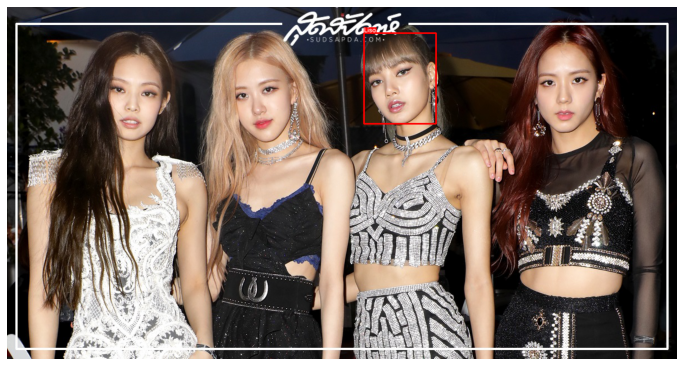

In [7]:
from PIL import Image
category_id_to_name = {0: "Lisa"}
image = np.array(Image.open(img_names[15]))
class_labels, bboxes = read_label(label_names[15])
visualize(image, bboxes, class_labels, category_id_to_name)

In [8]:
img_size = 416
train_transform = A.Compose([
    A.Resize(width=img_size, height=img_size),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.25, scale_limit=0.25, rotate_limit=45, p=0.5),
    A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.RGBShift(r_shift_limit=30, g_shift_limit=30, b_shift_limit=30, p=0.3),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'], min_visibility=0.2))

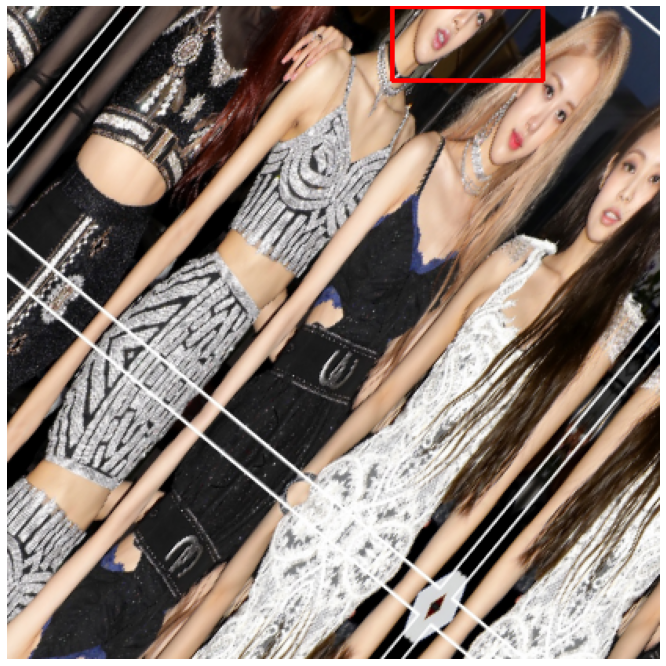

In [9]:
transformed = train_transform(image=image, bboxes=bboxes, class_labels=class_labels)
transformed_image = transformed['image']
transformed_bboxes = transformed['bboxes']
transformed_class_labels = transformed['class_labels']
visualize(transformed_image, transformed_bboxes, transformed_class_labels, category_id_to_name)

In [10]:
!mkdir LISA

In [11]:
outdir = "./LISA/"
for i in range(len(img_names)-5):#เก็บ5รูปสุดท้ายเป็นValidation Train16
    image = np.array(Image.open(img_names[i]))
    class_labels, bboxes = read_label(label_names[i])
    onlyname = img_names[i].split('/')[-1].split('.')[0]
    for ii in range(30):#จำนวนออคคิวเม็นเต็ด
        transformed = train_transform(image=image, bboxes=bboxes, class_labels=class_labels)
        transformed_image = transformed['image']
        transformed_bboxes = transformed['bboxes']
        transformed_class_labels = transformed['class_labels']
        transformed_name = onlyname+'_'+str(ii)
        cv2.imwrite(outdir + transformed_name +'.jpg', cv2.cvtColor(transformed_image, cv2.COLOR_RGB2BGR)) 
        out_file = open(outdir + transformed_name +'.txt', 'w')
        for iii in range(len(transformed_bboxes)):
            bIn  =  A.augmentations.bbox_utils.convert_bbox_to_albumentations(transformed_bboxes[iii], 'yolo', img_size, img_size, check_validity=True)
            bOut = A.augmentations.bbox_utils.convert_bbox_from_albumentations(bIn, 'yolo', img_size, img_size, check_validity=True)
            out_file.write(str(0) + " " + " ".join([str(b) for b in bOut]) + '\n')
        out_file.close()

In [12]:
!ls ./LISA/* #เช็คไฟล์Trainingว่ามีอะไรบ้าง

./LISA/d01_0.jpg   ./LISA/d05_0.jpg   ./LISA/d09_0.jpg	 ./LISA/d13_0.jpg
./LISA/d01_0.txt   ./LISA/d05_0.txt   ./LISA/d09_0.txt	 ./LISA/d13_0.txt
./LISA/d01_1.jpg   ./LISA/d05_1.jpg   ./LISA/d09_1.jpg	 ./LISA/d13_1.jpg
./LISA/d01_1.txt   ./LISA/d05_1.txt   ./LISA/d09_1.txt	 ./LISA/d13_1.txt
./LISA/d01_10.jpg  ./LISA/d05_10.jpg  ./LISA/d09_10.jpg  ./LISA/d13_10.jpg
./LISA/d01_10.txt  ./LISA/d05_10.txt  ./LISA/d09_10.txt  ./LISA/d13_10.txt
./LISA/d01_11.jpg  ./LISA/d05_11.jpg  ./LISA/d09_11.jpg  ./LISA/d13_11.jpg
./LISA/d01_11.txt  ./LISA/d05_11.txt  ./LISA/d09_11.txt  ./LISA/d13_11.txt
./LISA/d01_12.jpg  ./LISA/d05_12.jpg  ./LISA/d09_12.jpg  ./LISA/d13_12.jpg
./LISA/d01_12.txt  ./LISA/d05_12.txt  ./LISA/d09_12.txt  ./LISA/d13_12.txt
./LISA/d01_13.jpg  ./LISA/d05_13.jpg  ./LISA/d09_13.jpg  ./LISA/d13_13.jpg
./LISA/d01_13.txt  ./LISA/d05_13.txt  ./LISA/d09_13.txt  ./LISA/d13_13.txt
./LISA/d01_14.jpg  ./LISA/d05_14.jpg  ./LISA/d09_14.jpg  ./LISA/d13_14.jpg
./LISA/d01_14.txt  ./LISA/d05_14.

In [13]:
!mkdir LISA_VAL #สร้างFolder Val DATA

In [14]:
val_transform = A.Compose([
    A.Resize(width=img_size, height=img_size),#ปรับภาพให้ขนาดเท่ากัน416
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'], min_visibility=0.2))

In [15]:
outdir = "./LISA_VAL/"
for i in range(16, len(img_names)-1):
    image = cv2.imread(img_names[i])
    class_labels, bboxes = read_label(label_names[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    onlyname = img_names[i].split('/')[-1].split('.')[0]

    transformed = val_transform(image=image, bboxes=bboxes, class_labels=class_labels)
    transformed_image = transformed['image']
    transformed_bboxes = transformed['bboxes']
    transformed_class_labels = transformed['class_labels']
    transformed_name = onlyname
    cv2.imwrite(outdir + transformed_name +'.jpg', cv2.cvtColor(transformed_image, cv2.COLOR_RGB2BGR)) 
    out_file = open(outdir + transformed_name +'.txt', 'w')
    for iii in range(len(transformed_bboxes)):
        bIn  =  A.augmentations.bbox_utils.convert_bbox_to_albumentations(transformed_bboxes[iii], 'yolo', img_size, img_size, check_validity=True)
        bOut = A.augmentations.bbox_utils.convert_bbox_from_albumentations(bIn, 'yolo', img_size, img_size, check_validity=True)
        out_file.write(str(0) + " " + " ".join([str(b) for b in bOut]) + '\n')
    out_file.close()

In [16]:
!ls ./LISA_VAL/*

./LISA_VAL/d17.jpg  ./LISA_VAL/d18.jpg	./LISA_VAL/d19.jpg  ./LISA_VAL/d20.jpg
./LISA_VAL/d17.txt  ./LISA_VAL/d18.txt	./LISA_VAL/d19.txt  ./LISA_VAL/d20.txt


In [17]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
print(torch.__version__, torchvision.__version__)
os.getcwd()

1.7.1+cu110 0.8.2+cu110


'/kaggle/working'

In [18]:
!git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 9249, done.
remote: Total 9249 (delta 0), reused 0 (delta 0), pack-reused 9249
Receiving objects: 100% (9249/9249), 9.78 MiB | 6.70 MiB/s, done.
Resolving deltas: 100% (6422/6422), done.


In [19]:
os.chdir("/kaggle/working/yolov5")
!pip install -r ./requirements.txt

In [20]:
os.chdir("/kaggle/working/yolov5")
import glob
filename = glob.glob('/kaggle/working/LISA/*.jpg')
filename.sort()
f = open("./train.txt", "w")
for name in filename:
    f.write(name+"\n")
f.close()

filename = glob.glob('/kaggle/working/LISA_VAL/*.jpg')
filename.sort()
f = open("./val.txt", "w")
for name in filename:
    f.write(name+"\n")
f.close()

In [21]:
os.chdir("/kaggle/working/yolov5")
f = open("./train.yaml", "w")
f.write('train: ./train.txt'+"\n")
f.write('val: ./val.txt'+"\n")
f.write('nc: 1'+"\n")
f.write('names: [ \'LISA\' ]'+"\n")
f.close()

In [22]:
!wandb disabled

W&B disabled.


In [23]:
os.chdir("/kaggle/working/yolov5")
!python train.py --img 416 --batch 8 --epochs 100 --data train.yaml --cfg ./models/yolov5s.yaml --name LISARUN

train: weights=yolov5s.pt, cfg=./models/yolov5s.yaml, data=train.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=100, batch_size=8, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, entity=None, name=LISARUN, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, upload_dataset=False, bbox_interval=-1, save_period=-1, artifact_alias=latest, local_rank=-1, freeze=0, patience=100
github: up to date with https://github.com/ultralytics/yolov5 ✅
2021-09-27 15:36:23.817836: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
100%|██████████████████████████████████████| 14.1M/14.1M [00:00<00:00, 16.0MB/s]

train: Scanning 'train' images and labels...480 found, 0 missing, 14 empty, 0 co
val: Scanning 'val' images and labels...4 fou

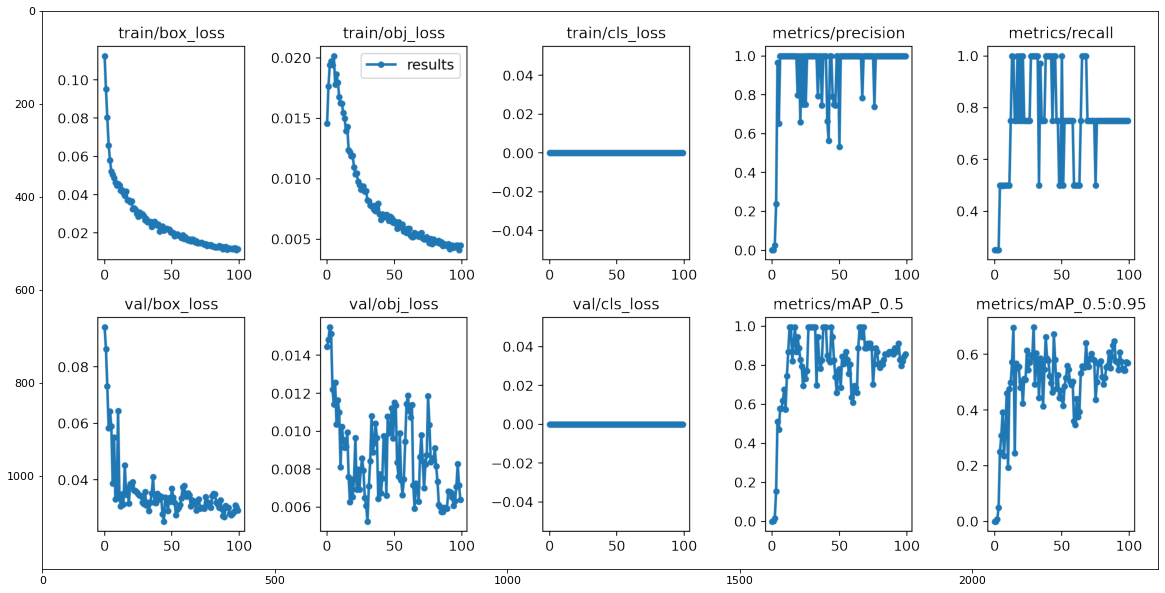

In [24]:
os.chdir("/kaggle/working/yolov5")
from utils.plots import plot_results 
plot_results('runs/train/LISARUN/results.csv')
image = np.array(Image.open('runs/train/LISARUN/results.png'))
plt.figure(figsize=(20, 20))
plt.imshow(image)

In [25]:
os.chdir("/kaggle/working/yolov5")
from models.experimental import attempt_load
from utils.torch_utils import select_device
weights = './runs/train/LISARUN/weights/best.pt'
device = select_device('cpu')
model = attempt_load(weights, map_location=device)  # load FP32 model
stride = int(model.stride.max())  # model stride
names = model.module.names if hasattr(model, 'module') else model.names  # get class names

In [26]:
os.chdir("/kaggle/working/yolov5")
from utils.datasets import LoadImages
from utils.general import check_img_size, non_max_suppression, scale_coords
from utils.plots import Annotator, colors
h = 416
w = 416
imgsz = check_img_size([h,w], s=stride) 
dataset = LoadImages('/kaggle/working/LISA_VAL/d19.jpg', img_size=imgsz, stride=stride, auto=True)

pred_results = []
for path, img, im0s, vid_cap in dataset:
    img = torch.from_numpy(img).to(device)
    img = img / 255.0
    if len(img.shape) == 3:
        img = img[None]
    pred = model(img)[0]
    pred = non_max_suppression(pred, 0.1, 0.45, None, False, max_det=1000)
    bboxes = []
    labels = []
    confs = []
    for i, det in enumerate(pred):
        if len(det):
            det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0s.shape).round()
            for *xyxy, conf, cls in reversed(det):
                labels.append(int(cls))
                confs.append(conf.item())
                xmin, ymin, xmax, ymax = xyxy
                xcen = (xmin + xmax) / 2 / w;
                ycen = (ymin + ymax) / 2 / h;
                ww = (xmax - xmin) / w;
                hh = (ymax - ymin) / h;
                bboxes.append([xcen.item(), ycen.item(), ww.item(), hh.item()])
    pred_results.append([path, bboxes, labels, confs])

image 1/1 /kaggle/working/LISA_VAL/d19.jpg: 

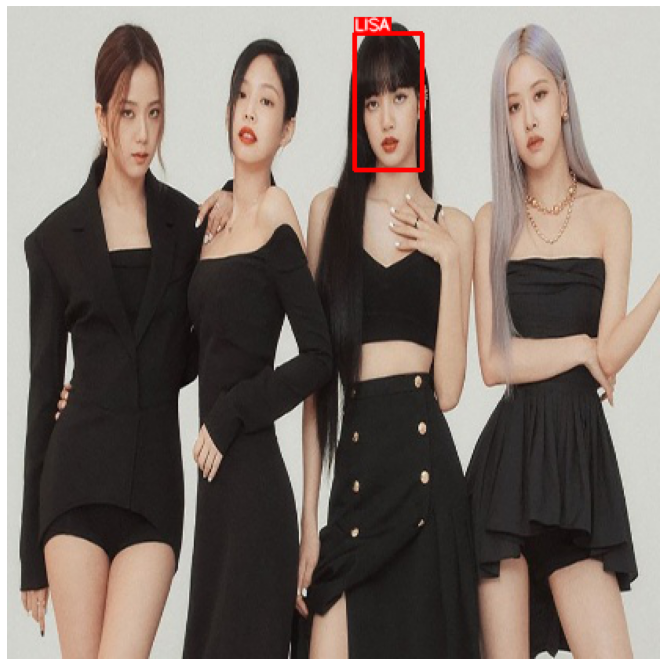

In [27]:
path, bboxes, labels, confs = pred_results[0]
image = np.array(Image.open(path))
visualize(image, bboxes, labels, names)

In [28]:
confs

[0.8525852560997009]